In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#MULTİPLE MODELS FOR PREDİCT SENTİMENTS

##YOL HARİTASI
1. KÜTÜPHANELERİ DAHİL EDELİM
2. DATASETİMİZİ İÇERİ AKTARALIM(LARGE DATASETS = SST>>> 60000 DEN FAZLA VERİ İÇERİYOR)
3. DATASET REVİEWS AND PREPORCESSİNG
4. TOKENİZE,PADDİNG AND TRUNCATE İŞLEMLERİ
5. PAD SEQUENCES TRAİN_AND_TEST DATASETLERİMİZİ OLUŞTURALIM
6. EMBEDDİNG MODELS CREATE , VİSUALİZE,AND PREDİCT
7. CNN MODEL CREATE
8. GRU MODEL CREATE
9. BİDİRECTİONAL LSTM MODEL CREATE
10. MULTİPLE BİDİRECTİONAL MODEL CREATE
11.COMPARE ALL MODELS


##1-İMPORTİNG LİBRARİES

In [2]:
#pandas and numpy
import pandas as pd
import numpy as np 

# tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds

# Tokenizer and pad_sequence import from tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##2-GET THE DATASETS

In [3]:
dataset,info = tfds.load('glue/sst2',with_info = True)
print(info.features)
print(info.features['label'].num_classes)
print(info.features['label'].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteZKNLHX/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteZKNLHX/glue-validation.tfrecord*...:   0%|      …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteZKNLHX/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


##3-TRAİN VE VALİDATİONS DATASETLERİMİZİ OLUŞTURALIM


In [4]:
dataset_train , dataset_validation =  dataset['train'],dataset['validation']
dataset_train

<PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [5]:
#Bazı verilere göz atalım
for example in dataset_train.take(2):
  review,label = example['sentence'],example['label']
  print("Review :" , review)
  print("Label: %d \n" % label.numpy())

Review : tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review : tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



##4-Get the Sentences and Labels for both the training and the validation sets
  * Cümleleri ve etiketleri(0 ve 1) training ve validation setleri için alalım


In [6]:
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels=[]

# Veri setinin içerisinde 67000 girdi bulunuyor
# uzun sürmemesi için 10000 veri alalım,
# Hepsini almak istiyorsak for item in dataset_train.take(-1) yaparız

for item in dataset_train.take(10000):
  review,label = item['sentence'],item['label']
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())


print("\nNumber of training reviews is :" , len(training_reviews))

# aldığımız bazı training_reviews ve training_labelslara bakalım
for i in range(0,2):
  print(training_reviews[i])
  print(training_labels[i])

# Validations reviews ve labels ları alalım
# 800 küsur adet veriden oluşuyor hepsini alalım

for item in dataset_validation.take(-1):
  review,label = item['sentence'],item['label']
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print("\nNumber of validation reviews is : " , len(validation_reviews))

# validation setimize de bir göz gezdirelim
for i in range(0,2):
  print(validation_reviews[i])
  print(validation_labels[i])


Number of training reviews is : 10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is :  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


##5-Tokenize the words and sequence the sentences
  * Toplam gerekli gereksiz 21224 adet kelime var(Bazıları anlamsız)
  * Bir cümlenin içerisinde 50 kelime olarak belirleyelim(max_length = 50)
  * En yaygın 4000 kelime (vocab_Size = 4000)
  * embedding_dim = 16

In [7]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
padding_type = 'post'
trunc_type = 'post'
oov_tok = "<OOV>"

# create instance
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

##6-Padding sequences
  * Dizilerin hepsini aynı uzunlukta yappak için padding and truncate işlemlerini yapalım max_length = 50

In [9]:
# training sequences and padding
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen = max_length,padding= padding_type,truncating = trunc_type)

# validation reviews sequences and padding
validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen = max_length,padding= padding_type,truncating = trunc_type)

# Sonrası için etiketlerini kayıt edelim 
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

##7-First Model Create with Embedding and GlobalAveragePooling1D

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


##8-Train First Model

In [11]:
num_epochs = 20
history = model.fit(
    training_padded,
    training_labels_final,
    epochs = num_epochs,
    validation_data =(validation_padded,validation_labels_final) 
)

Epoch 1/20
313/313 [==============================] - 21s 51ms/step - loss: 0.6838 - accuracy: 0.5592 - val_loss: 0.6902 - val_accuracy: 0.5115
Epoch 2/20
313/313 [==============================] - 4s 14ms/step - loss: 0.6732 - accuracy: 0.5695 - val_loss: 0.6729 - val_accuracy: 0.5986
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 0.6523 - accuracy: 0.6184 - val_loss: 0.6468 - val_accuracy: 0.6353
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 0.6228 - accuracy: 0.6727 - val_loss: 0.6136 - val_accuracy: 0.6881
Epoch 5/20
313/313 [==============================] - 2s 7ms/step - loss: 0.5887 - accuracy: 0.7061 - val_loss: 0.5828 - val_accuracy: 0.7225
Epoch 6/20
313/313 [==============================] - 1s 5ms/step - loss: 0.5549 - accuracy: 0.7433 - val_loss: 0.5554 - val_accuracy: 0.7179
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.5230 - accuracy: 0.7682 - val_loss: 0.5325 - val_accuracy: 0.7511
Ep

##9-Visualize accuracy and loss

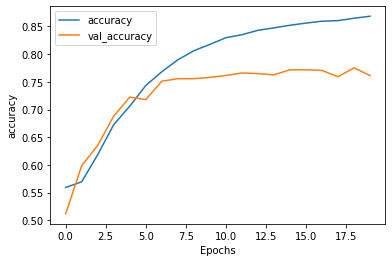

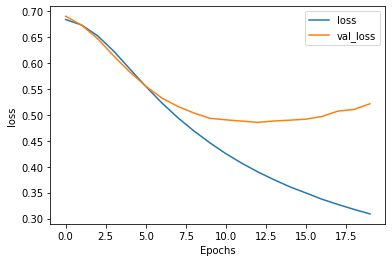

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

##10-Write a function to predict the sentiment of reviews
  * Pratiklik açısından olumlu olumsuz olmasını tahmin fonksiyonu yazalım

In [13]:
# Örnek olması için bazı kelimeler tanımlayalım
review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [15]:
# Fonksiyonu yazalım sonra tahmin için kullanalım
#  1: Fonksiyon parametresini belirle (Kullanılacak model , tahmin edilecek cümle)
#  2. Girilen cümleyi tokenize sequence işlemi ve standartlaştırmak için padding işlemleri uygula
# 3 . Tahmin et model.predict(reviews_padded)

def predict_review(model,reviews):
  padding_type = 'post'
  trunc_type = 'post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences,maxlen = max_length,padding=padding_type,truncating = trunc_type)

  classes = model.predict(reviews_padded)
  for i in range(len(reviews_padded)):
    print("Reviews is : " , reviews[i])
    print('Predict Sentiment is : ' , classes[i])
    print('\n')

predict_review(model,new_reviews)

1/1 [==============================] - 0s 102ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.4264992]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.12839082]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.03374468]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.6268196]




##11-Define a function to train and show the results of models with different layers
  * FARKLI KATMANLARA SAHİP MODELLERİ PRATİK OLARAK UYGULAMAK İÇİN FONKSİYON TANIMLAYALIM

In [16]:
# 1-Fonksiyon parametrelerini tanımla(kullanılacak model , girlecek cümler/cümleler)
# 2-Modelin özetinin göreceğimiz summary() kullan
# 3- Model eğitimi uygula(model.fit() işlemi)
# 4- Visualize accuracy and loss kullan
# 5- predict_reviews uygula

def fit_model_and_predict_reviews(model,reviews):
  model.summary()
  history = model.fit(
      training_padded,
      training_labels_final,
      epochs = num_epochs,
      validation_data = (validation_padded,validation_labels_final)
  )

  plot_graphs(history,'accuracy')
  plot_graphs(history,"loss")
  predict_review(model,reviews)

##12-Create Diffirent Models
  1. CNN
  2. GRU
  3. BİDİRECTİONAL LSTM
  4. MULTİPLE BİDİRECTİONAL LSTM

#12.1-CREATE AND USE CNN

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 18s 36ms/step - loss: 0.6928 - accuracy: 0.5115 - val_loss: 0.

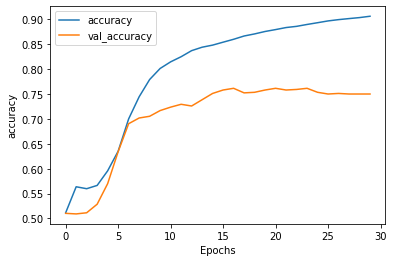

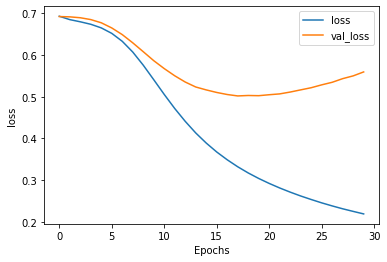

1/1 [==============================] - 0s 83ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.9263711]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.0123285]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.00447455]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.7674337]




In [20]:


num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.Conv1D(16,5,activation='relu'), # filtre,kernel_size
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

# Optimizer adam ın varsayılan öğrenme oranı 0.001 dir.Bunu 10 kat azaltalım 0.0001 yapalım
learning_rate = 0.0001
model_cnn.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy']
)

fit_model_and_predict_reviews(model_cnn,new_reviews)

##12.2-CREATE AND USE GRU

In [ ]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

# öğrenme hızını azaltalım
learning_rate = 0.00003
model_gru.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy']
)

fit_model_and_predict_reviews(model_gru,new_reviews)


##12.3-CREATE AND USE BİDİRECTİONAL LSTM

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 17s 42ms/step - loss: 0.6911 - accuracy: 0.5512 - val_loss: 0.6930 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 4s 14ms/step - loss: 0.6878 - accuracy: 0.5590 - v

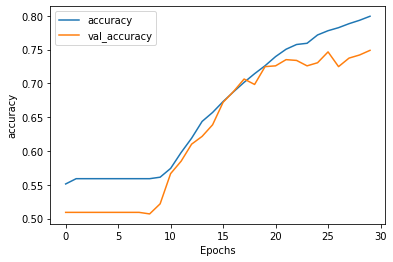

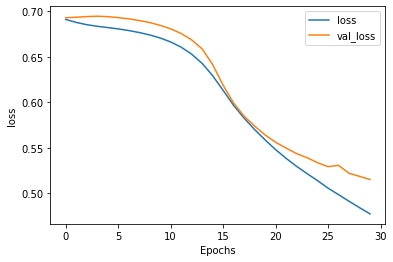

1/1 [==============================] - 1s 620ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.44798434]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.33317736]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.37434593]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.51066935]




In [23]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1,activation ='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy']
)

fit_model_and_predict_reviews(model_bidi_lstm,new_reviews)

##12.4-CREATE AND USE MULTİPLE BİDİRECTİONAL LSTM

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================

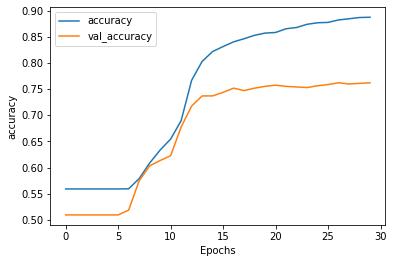

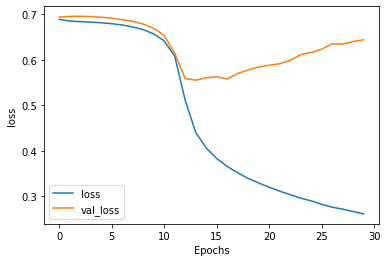

1/1 [==============================] - 2s 2s/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.70706844]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.0704821]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.0624896]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.96936834]




In [24]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

learning_rate = 0.00003
model_multiple_bidi_lstm.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy']
)

fit_model_and_predict_reviews(model_multiple_bidi_lstm,new_reviews)

##13-Try some more reviews

In [25]:

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]


In [26]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
1/1 [==============================] - 0s 47ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.4264992]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.12839082]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.03374468]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.6268196]


Reviews is :  I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
Predict Sentiment is :  [0.27247268]


Reviews is :  I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
Predict Sentiment is :  [0.50054175]


Reviews is :  the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
Predict Sentimen

In [27]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 [==============================] - 0s 34ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.9263711]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.0123285]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.00447455]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.7674337]


Reviews is :  I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
Predict Sentiment is :  [0.38651538]


Reviews is :  I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
Predict Sentiment is :  [0.58509237]


Reviews is :  the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
Predict Sentiment is :  [

In [28]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
1/1 [==============================] - 0s 22ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.34009036]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.15414523]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.13259216]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.49213567]


Reviews is :  I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
Predict Sentiment is :  [0.08675176]


Reviews is :  I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
Predict Sentiment is :  [0.13841742]


Reviews is :  the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
Predict 

In [29]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 [==============================] - 0s 20ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.44798434]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.33317736]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.37434593]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.51066935]


Reviews is :  I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
Predict Sentiment is :  [0.38677898]


Reviews is :  I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
Predict Sentiment is :  [0.30717006]


Reviews is :  the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talke

In [30]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 [==============================] - 0s 23ms/step
Reviews is :  I loved this movie
Predict Sentiment is :  [0.70706844]


Reviews is :  that was the worst movie I've ever seen
Predict Sentiment is :  [0.0704821]


Reviews is :  too much violence even for a Bond film
Predict Sentiment is :  [0.0624896]


Reviews is :  a captivating recounting of a cherished myth
Predict Sentiment is :  [0.96936834]


Reviews is :  I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
Predict Sentiment is :  [0.13225871]


Reviews is :  I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
Predict Sentiment is :  [0.39934197]


Reviews is :  the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!